In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-dig-dep-hack-updated/test.csv
/kaggle/input/sentiment-analysis-of-financial-news-headlines/sample_submission.csv
/kaggle/input/sentiment-analysis-of-financial-news-headlines/train.csv
/kaggle/input/sentiment-analysis-of-financial-news-headlines/test.csv


In [2]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-of-financial-news-headlines/train.csv', sep=';')
df.head(5)

,id,text,sber,vtb,gazprom,alfabank,raiffeisen,rshb,company
0,8292,#novosti Сбербанк и ВТБ пообещали выполнить об...,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,10897,Корея может стать следующей Японией для инвест...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3964,#Новые санкции затрагивают и Газпромбанк #sledui,NaN,NaN,-1.0,NaN,NaN,NaN,NaN
3,11829,VEON заявила об обесценивании бизнеса в России...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
4,18814,банк втб ипотечный кредит,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(7161, 9)

In [5]:
bank_columns = ['sber', 'vtb', 'gazprom', 'alfabank', 'raiffeisen', 'rshb']

n_banks = 6

In [6]:
df['is_bank'] = np.zeros_like(df['text'])

df['is_company'] = np.zeros_like(df['text'])

In [7]:
for index, row in df[bank_columns].iterrows():
    if row.isna().sum() == n_banks:
        df.loc[index, "is_bank"] = 0.0
    else:
        df.loc[index, "is_bank"] = 1.0

In [8]:
for index, row in df[['company']].iterrows():
    if row.isna().sum() == 1.0:
        df.loc[index, "is_company"] = 0.0
    else:
        df.loc[index, "is_company"] = 1.0

In [9]:
bank_pattern = r'банк|bank'
sber_pattern = r'sber|сбер|sberbank|сбербанк'
vtb_pattern = r'vtb|втб|внешторгбанк|бтв'
gazprom_pattern = r'gazprombank|гпб|газпромбанк'
alfabank_pattern = r'alfa|alfabank|alfa-bank|альфа|альфабанк|альфа-банк'
raiffeisen_pattern = r'raiffeisen|raif|райффайзен|рфб|райф|райфф|райфазен|раиффайзен|раиф'
rshb_pattern = r'rshb|россельхоз|россельхозбанк|рсх|рсхб'
uralsib_pattern = r'уралсиб|uralsib'
company_pattern = r'лукойл|россети|veon|северстал|hershey|booking|куйбышевазот|\
pepsi|heinz|pfizer|siemens|polymetal|энел|uber|halliburton\
|moderna|accenture|cisco|wintershall|интеррос|johnson|тгк-2|маск|роснефт|аэрофлот|новатэк|apple|samsung|акрон|яндекс|лента|мтс|магнит|совкомфлот|нлмк|алрос|shell|ммк| \
nasa|mastercard|ростелеком|jpmorgan|hsbc|netflix|qiwi|киви|moody|сдэк|qatarenergy|ercsson|nokia|google|xiaomi|vmware|avito'

In [10]:
df['is_sber'] = df['text'].str.contains(sber_pattern, case=False) * df['text'].str.contains(bank_pattern, case=False)

df['is_vtb'] = df['text'].str.contains(vtb_pattern, case=False)

df['is_gazprom'] = df['text'].str.contains(gazprom_pattern, case=False)

df['is_alfabank'] = df['text'].str.contains(alfabank_pattern, case=False)

df['is_raiffeisen'] = df['text'].str.contains(raiffeisen_pattern, case=False)

df['is_rshb'] = df['text'].str.contains(rshb_pattern, case=False)

df['is_company_pattern'] = df['text'].str.contains(company_pattern, case=False)

In [11]:
df['sent'] = np.zeros_like(df['text']) * np.nan

In [12]:
sent_columns = ['sber', 'vtb', 'gazprom', 'alfabank', 'raiffeisen', 'rshb', 'company']

In [13]:
for index, row in df[sent_columns].iterrows():
    df.loc[index, 'sent'] = np.max(row)

In [14]:
df_w_sent = df.query('not (is_bank == 0.0 and is_company == 0.0)').copy()
df_w_sent

,id,text,sber,vtb,gazprom,alfabank,raiffeisen,rshb,company,is_bank,is_company,is_sber,is_vtb,is_gazprom,is_alfabank,is_raiffeisen,is_rshb,is_company_pattern,sent
0,8292,#novosti Сбербанк и ВТБ пообещали выполнить об...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,True,False,False,False,False,False,1.0
2,3964,#Новые санкции затрагивают и Газпромбанк #sledui,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,1.0,0.0,False,False,True,False,False,False,False,-1.0
3,11829,VEON заявила об обесценивании бизнеса в России...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,False,False,False,False,False,False,True,-1.0
4,18814,банк втб ипотечный кредит,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,False,True,False,False,False,False,False,0.0
5,6466,Оформить кредит россельхозбанк,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,False,False,False,False,False,True,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7156,3721,У твиттера Сбербанка 42 тыс.читателейВТБ13 тыс.,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,True,False,False,False,False,False,0.0
7157,18578,заместителя руководителя пошёл на повышение кл...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,False,False,False,False,False,False,0.0
7158,91,Оформить кредитную карту альфа банк,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,0.0,False,False,False,True,False,False,False,0.0
7159,14728,Кредиты малого бизнеса втб 24 г иркутск,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,False,True,False,False,False,False,False,0.0


Undersampling

In [142]:
count_class_0, count_class_n, count_class_p = df_w_sent.sent.value_counts()
df_w_sent.sent.value_counts()

sent
 0.0    4651
-1.0    1119
 1.0    1102
Name: count, dtype: int64

In [143]:
# Divide by class
df_class_0 = df_w_sent[df_w_sent.sent == 0.0].copy()
df_class_n = df_w_sent[df_w_sent.sent == -1.0].copy()
df_class_p = df_w_sent[df_w_sent.sent == 1.0].copy()

In [144]:
df_class_0_under = df_class_0.sample(count_class_p).copy()
df_class_n_under = df_class_n.sample(count_class_p).copy()

In [145]:
df_w_sent_under = pd.concat([df_class_0_under, df_class_n_under, df_class_p], axis=0)
df_w_sent_under

,id,text,sber,vtb,gazprom,alfabank,raiffeisen,rshb,company,is_bank,is_company,is_sber,is_vtb,is_gazprom,is_alfabank,is_raiffeisen,is_rshb,is_company_pattern,sent
2339,16897,ипотечный кредит газпромбанка,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,0.0,False,False,True,False,False,False,False,0.0
6759,3582,структура кредитного портфеля альфабанка,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,0.0,False,False,False,True,False,False,False,0.0
6812,7810,Как взять кредит за 1 день в альфа банке,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,0.0,False,False,False,True,False,False,False,0.0
3862,10137,ВТБ разместит 30 января однодневные бонды сери...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,False,True,False,False,False,False,False,0.0
2079,471,ВТБ размещает однодневные облигации на 100 млр...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,False,True,False,False,False,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,18554,"Аналитики ждут щедрых дивидендов от Сбербанка,...",1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,False,False,False,False,False,False,1.0
7131,18660,Газпромбанк в 2022г увеличил розничный кредитн...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,0.0,False,False,True,False,False,False,False,1.0
7139,153,Немецкая VNG согласилась платить за газ через ...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,0.0,False,False,True,False,False,False,False,1.0
7140,5820,Через Сбербанк Онл@йн теперь возможно оплачива...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,True,False,False,False,False,False,False,1.0


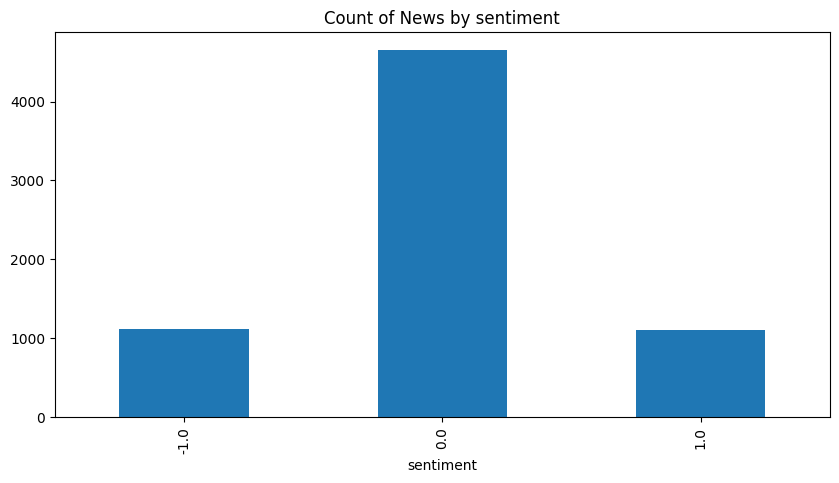

In [146]:
ax = df_w_sent['sent'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of News by sentiment',
          figsize=(10, 5))
ax.set_xlabel('sentiment')
plt.show()

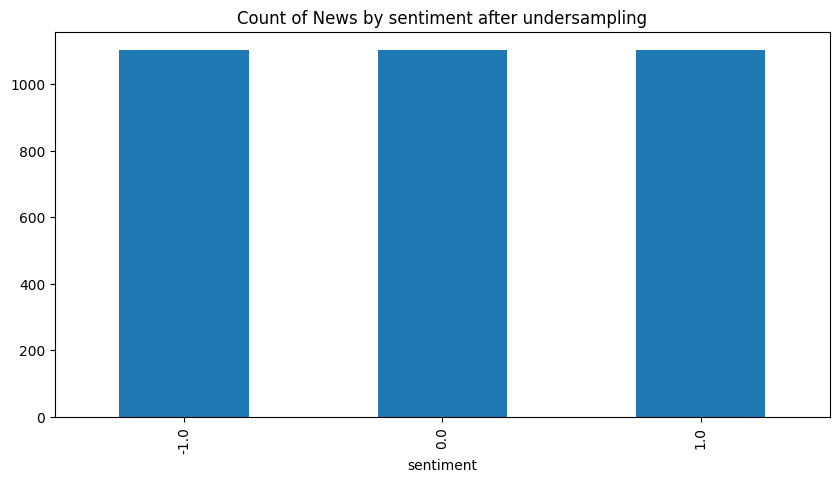

In [147]:
ax = df_w_sent_under['sent'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of News by sentiment after undersampling',
          figsize=(10, 5))
ax.set_xlabel('sentiment')
plt.show()

In [15]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
stopWords = set(stopwords.words('russian'))

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('russian'))
nltk.download('wordnet')
wnl = nltk.SnowballStemmer('russian')
# wnl = nltk.SnowballStemmer()

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
import re

def clean_text(text):
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    text = re.sub(r'<.*?>', '', text)    # Remove HTML tags
    text = text.lower()                  # Convert to lowercase
    return text

In [20]:
# df_w_sent['text'] = df_w_sent['text'].apply(clean_text)
# df_w_sent

In [21]:
def preproc_nltk(text):
    #text = re.sub(f'[{string.punctuation}]', ' ', text)
#     return ' '.join([wnl.lemmatize(word) for word in word_tokenize(text.lower()) if word not in stopWords])
#     return ' '.join([wnl.stem(word) for word in word_tokenize(text.lower()) if word not in stopWords])
    return ' '.join([wnl.stem(word) for word in word_tokenize(text.lower()) if word not in stopWords])

In [22]:
import gensim

In [23]:
# tokenized_text = df_w_sent['text'].apply(lambda x: x.split()) # tokenizing 

In [25]:
tokenized_text = df_w_sent['text'].apply(lambda x: word_tokenize(x))

In [27]:
tokenized_by_wt_text = df_w_sent['text'].apply(lambda x: word_tokenize(x))
tokenized_by_wt_text

0       [#, novosti, Сбербанк, и, ВТБ, пообещали, выпо...
2       [#, Новые, санкции, затрагивают, и, Газпромбан...
3       [VEON, заявила, об, обесценивании, бизнеса, в,...
4                          [банк, втб, ипотечный, кредит]
5                      [Оформить, кредит, россельхозбанк]
                              ...                        
7156    [У, твиттера, Сбербанка, 42, тыс.читателейВТБ1...
7157    [заместителя, руководителя, пошёл, на, повышен...
7158            [Оформить, кредитную, карту, альфа, банк]
7159      [Кредиты, малого, бизнеса, втб, 24, г, иркутск]
7160                      [Образец, печати, альфа, банка]
Name: text, Length: 6872, dtype: object

In [28]:
for idx in np.array(tokenized_text.index):
    tokenized_text[idx] = [wnl.stem(word) for word in tokenized_text[idx] if word not in stopWords]

In [29]:
tokenized_text

0       [#, novost, сбербанк, втб, пообеща, выполн, об...
2       [#, нов, санкц, затрагива, газпромбанк, #, sledu]
3       [VEON, заяв, обесцениван, бизнес, росс, $, 449...
4                              [банк, втб, ипотечн, кред]
5                           [оформ, кред, россельхозбанк]
                              ...                        
7156    [у, твиттер, сбербанк, 42, тыс.читателейвтб13,...
7157    [заместител, руководител, пошел, повышен, клие...
7158                   [оформ, кредитн, карт, альф, банк]
7159           [кредит, мал, бизнес, втб, 24, г, иркутск]
7160                         [образец, печат, альф, банк]
Name: text, Length: 6872, dtype: object

In [30]:
model_w2v = gensim.models.Word2Vec(
            tokenized_text,
            vector_size=300, # desired no. of features/independent variables
            window=5, # context window size
            min_count=3, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
#             negative = 20, # for negative sampling
#             workers= 32, # no.of cores
#             seed = 34
) 

In [32]:
model_w2v.train(tokenized_text, total_examples= len(df_w_sent['text']), epochs=200)

(8032074, 12647000)

In [33]:
model_w2v.wv.most_similar(positive="банк")

[('альф', 0.37874481081962585),
 ('райфайзенбанкавал', 0.3197726607322693),
 ('оренбург', 0.30706414580345154),
 ('классическ', 0.30609723925590515),
 ('физ', 0.3031288981437683),
 ('экспресс', 0.299204558134079),
 ('заполн', 0.28980153799057007),
 ('народн', 0.28921809792518616),
 ('ставропол', 0.2859569787979126),
 ('внешторгбанк', 0.2841300964355469)]

In [36]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [37]:
np.array(tokenized_text.index)

array([   0,    2,    3, ..., 7158, 7159, 7160])

In [38]:
len(tokenized_text)

6872

In [41]:
tokenized_text[15]

['крупн',
 'российск',
 'банк',
 'сбербанк',
 'втб',
 'попада',
 'санкц',
 'ес',
 '#',
 'dknews']

In [42]:
wordvec_arrays = np.zeros((len(tokenized_text), 300)) 
for i, index in enumerate(np.array(tokenized_text.index)):
    wordvec_arrays[i,:] = word_vector(tokenized_text[index], 300)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(6872, 300)

In [43]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [44]:
X = np.array(wordvec_df)

In [45]:
X.shape

(6872, 300)

In [46]:
sent_mapping = {-1: 'n',
               0: '0',
               1: 'p'}

In [48]:
y = df_w_sent['sent'].map(sent_mapping).copy()
y

0       p
2       n
3       n
4       0
5       0
       ..
7156    0
7157    0
7158    0
7159    0
7160    0
Name: sent, Length: 6872, dtype: object

In [49]:
val_size = 0.3
X_train, X_val, y_train, y_val= train_test_split(X, y, stratify=y, test_size=val_size, random_state=15)

In [50]:
X_train.shape

(4810, 300)

In [51]:
clf = SGDClassifier(max_iter=500, warm_start=True)

In [52]:
clf.fit(X_train, y_train)

SGDClassifier(max_iter=500, warm_start=True)

In [53]:
f1_score(y_val, clf.predict(X_val), average="macro")

0.694328000654222

In [54]:
from sklearn.linear_model import LogisticRegression

log_reg_clf = LogisticRegression(solver='sag')

log_reg_clf.fit(X_train, y_train)

LogisticRegression(solver='sag')

In [55]:
f1_score(y_val, log_reg_clf.predict(X_val), average="macro")

0.688860334017899

In [56]:
from sklearn import svm

svc = svm.SVC(kernel='rbf', C=15, probability=True).fit(X_train, y_train) 
prediction = svc.predict(X_val) 

In [57]:
f1_score(y_val, prediction, average="macro")

0.7708122187751402

In [58]:
from sklearn.model_selection import cross_val_score
svc = svm.SVC(kernel='rbf', C=5, random_state=42)
scores = cross_val_score(svc, X, y, cv=5, scoring='f1_micro')

In [59]:
scores

array([0.83927273, 0.85163636, 0.81804949, 0.85080058, 0.83333333])

In [60]:
svc.fit(X_train, y_train)

SVC(C=5, random_state=42)

In [184]:
# df_test = pd.read_csv('/kaggle/input/sentiment-analysis-of-financial-news-headlines/test.csv', sep=';')
# df_test.head()

In [61]:
df_test = pd.read_csv('/kaggle/input/test-dig-dep-hack-updated/test.csv', sep=';')
df_test.head()

,id,text
0,2807,Банк втб киров взять кредитную карту через онлайн
1,5231,должники по кредитам сбербанка
2,9155,RT @RT_russian: ЕС ограничил доступ к рынкам к...
3,2525,Zaletchikya В Сочи банкоматы Сбербанка будут н...
4,7702,RT @etuduvudp: Сбербанк прислал СМС о возможно...


In [62]:
# df_test['text'] = df_test['text'].apply(clean_text)
# df_test

In [63]:
test_tokenized_text = df_test['text'].apply(lambda x: word_tokenize(x))

In [64]:
for idx in np.array(test_tokenized_text.index):
    test_tokenized_text[idx] = [wnl.stem(word) for word in test_tokenized_text[idx] if word not in stopWords]

In [65]:
test_wordvec_arrays = np.zeros((len(test_tokenized_text), 300)) 
for i, index in enumerate(np.array(test_tokenized_text.index)):
    test_wordvec_arrays[i,:] = word_vector(test_tokenized_text[index], 300)
test_wordvec_df = pd.DataFrame(test_wordvec_arrays)
test_wordvec_df.shape

(4788, 300)

In [66]:
test_vectors = np.array(test_wordvec_df)

In [67]:
test_vectors.shape

(4788, 300)

In [68]:
test_pred = svc.predict(test_vectors)

In [69]:
df_test['clf_sent'] = test_pred

In [194]:
df_test.sample(10)

,id,text,clf_sent
3723,18926,ставка ипотечного кредита сбербанк,0
430,17362,кредитные карты без справок онлайн оформление ...,0
2684,8126,@D_Babich сбер собираюсь открыть сегодня.,p
2220,16117,Газпромбанк приостанавливает переводы в доллар...,n
746,16829,Банк втб 24 кредиты,0
4251,17660,ставки газпромбанка на краткосрочные кредиты,0
4650,10978,| Оформление кредита альфа банке,0
3029,1256,кредит на отдых в сбербанке,0
181,3897,сбербанк кредит малого бизнеса,0
2412,9045,кредиты на автомобили альфа банк,0


In [70]:
sent_inv_mapping = {'n': -1,
               '0': 0,
               'p': 1}

In [71]:
df_test['clf_sent'] = df_test.clf_sent.map(sent_inv_mapping)
df_test

,id,text,clf_sent
0,2807,Банк втб киров взять кредитную карту через онлайн,0
1,5231,должники по кредитам сбербанка,0
2,9155,RT @RT_russian: ЕС ограничил доступ к рынкам к...,-1
3,2525,Zaletchikya В Сочи банкоматы Сбербанка будут н...,0
4,7702,RT @etuduvudp: Сбербанк прислал СМС о возможно...,0
...,...,...,...
4783,2380,«Аэрофлот» впервые отправил самолет на ремонт ...,1
4784,17995,RT @morketolog: Цифра дня: средняя зарплата в ...,0
4785,7571,«Аэрофлот» получит 63 отечественных самолета в...,1
4786,6279,Лондон включил в санкционные списки по РФ боле...,-1


In [72]:
df_test['is_sber'] = df_test['text'].str.contains(sber_pattern, case=False)

df_test['is_vtb'] = df_test['text'].str.contains(vtb_pattern, case=False)

df_test['is_gazprom'] = df_test['text'].str.contains(gazprom_pattern, case=False)

df_test['is_alfabank'] = df_test['text'].str.contains(alfabank_pattern, case=False)

df_test['is_raiffeisen'] = df_test['text'].str.contains(raiffeisen_pattern, case=False)

df_test['is_rshb'] = df_test['text'].str.contains(rshb_pattern, case=False)

df_test['is_company_pattern'] = df_test['text'].str.contains(company_pattern, case=False)

In [73]:
is_bank_columns = [
#     'is_bank', 
                   'is_sber', 'is_vtb', 'is_gazprom', 'is_alfabank', 'is_raiffeisen', 'is_rshb']

In [199]:
df_test['is_company'] = np.nan * np.ones_like(df_test['text'])

In [200]:
for index, row in df_test[is_bank_columns].iterrows():
#     if np.sum(row) == 0 and df_test.loc[index, 'is_company_pattern'] == True:
    if (np.sum(row) == 0 and df_test.loc[index, 'is_company_pattern'] == True):
        df_test.loc[index, 'is_company'] = True
    else:
        df_test.loc[index, 'is_company'] = False

In [201]:
sentiments = ['n', '0', 'p']

In [202]:
for bank in bank_columns:
    for sentiment in sentiments:
        df_test[f'{bank}_{sentiment}'] = np.ones_like(df_test['text'])

In [203]:
df_test['clf_sent_label'] = df_test['clf_sent'].map(sent_mapping)
df_test

,id,text,clf_sent,is_sber,is_vtb,is_gazprom,is_alfabank,is_raiffeisen,is_rshb,is_company_pattern,...,alfabank_n,alfabank_0,alfabank_p,raiffeisen_n,raiffeisen_0,raiffeisen_p,rshb_n,rshb_0,rshb_p,clf_sent_label
0,2807,Банк втб киров взять кредитную карту через онлайн,0,False,True,False,False,False,False,False,...,1,1,1,1,1,1,1,1,1,0
1,5231,должники по кредитам сбербанка,0,True,False,False,False,False,False,False,...,1,1,1,1,1,1,1,1,1,0
2,9155,RT @RT_russian: ЕС ограничил доступ к рынкам к...,-1,True,True,True,False,False,True,False,...,1,1,1,1,1,1,1,1,1,n
3,2525,Zaletchikya В Сочи банкоматы Сбербанка будут н...,0,True,False,False,False,False,False,False,...,1,1,1,1,1,1,1,1,1,0
4,7702,RT @etuduvudp: Сбербанк прислал СМС о возможно...,1,True,False,False,False,False,False,True,...,1,1,1,1,1,1,1,1,1,p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4783,2380,«Аэрофлот» впервые отправил самолет на ремонт ...,1,False,False,False,False,False,False,True,...,1,1,1,1,1,1,1,1,1,p
4784,17995,RT @morketolog: Цифра дня: средняя зарплата в ...,-1,False,False,True,False,False,False,False,...,1,1,1,1,1,1,1,1,1,n
4785,7571,«Аэрофлот» получит 63 отечественных самолета в...,1,False,False,False,False,False,False,True,...,1,1,1,1,1,1,1,1,1,p
4786,6279,Лондон включил в санкционные списки по РФ боле...,-1,False,False,False,False,False,False,False,...,1,1,1,1,1,1,1,1,1,n


In [204]:
for index, row in df_test.iterrows():
    for bank in bank_columns:
        for sentiment in sentiments:
            if ((row[f'is_{bank}'] == True) and (row['clf_sent_label'] == sentiment)):
                df_test.loc[index, f'{bank}_{sentiment}'] = 1
            else:
                df_test.loc[index, f'{bank}_{sentiment}'] = 0
    for sentiment in sentiments:
        if ((row[f'is_company'] == True) and (row['clf_sent_label'] == sentiment)):
            df_test.loc[index, f'company_{sentiment}'] = 1
        else:
            df_test.loc[index, f'company_{sentiment}'] = 0

In [205]:
df_test

,id,text,clf_sent,is_sber,is_vtb,is_gazprom,is_alfabank,is_raiffeisen,is_rshb,is_company_pattern,...,raiffeisen_n,raiffeisen_0,raiffeisen_p,rshb_n,rshb_0,rshb_p,clf_sent_label,company_n,company_0,company_p
0,2807,Банк втб киров взять кредитную карту через онлайн,0,False,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0.0,0.0,0.0
1,5231,должники по кредитам сбербанка,0,True,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0.0,0.0,0.0
2,9155,RT @RT_russian: ЕС ограничил доступ к рынкам к...,-1,True,True,True,False,False,True,False,...,0,0,0,1,0,0,n,0.0,0.0,0.0
3,2525,Zaletchikya В Сочи банкоматы Сбербанка будут н...,0,True,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0.0,0.0,0.0
4,7702,RT @etuduvudp: Сбербанк прислал СМС о возможно...,1,True,False,False,False,False,False,True,...,0,0,0,0,0,0,p,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4783,2380,«Аэрофлот» впервые отправил самолет на ремонт ...,1,False,False,False,False,False,False,True,...,0,0,0,0,0,0,p,0.0,0.0,1.0
4784,17995,RT @morketolog: Цифра дня: средняя зарплата в ...,-1,False,False,True,False,False,False,False,...,0,0,0,0,0,0,n,0.0,0.0,0.0
4785,7571,«Аэрофлот» получит 63 отечественных самолета в...,1,False,False,False,False,False,False,True,...,0,0,0,0,0,0,p,0.0,0.0,1.0
4786,6279,Лондон включил в санкционные списки по РФ боле...,-1,False,False,False,False,False,False,False,...,0,0,0,0,0,0,n,0.0,0.0,0.0


In [206]:
for sentiment in sentiments:
    df_test[f'company_{sentiment}'] = df_test[f'company_{sentiment}'].astype('int')
    
for bank in bank_columns:
    for sentiment in sentiments:
        df_test[f'{bank}_{sentiment}'] = df_test[f'{bank}_{sentiment}'].astype('int')

In [207]:
submission_columns = ['id', 'sber_n',
       'sber_0', 'sber_p', 'vtb_n', 'vtb_0', 'vtb_p', 'gazprom_n', 'gazprom_0',
       'gazprom_p', 'alfabank_n', 'alfabank_0', 'alfabank_p', 'raiffeisen_n',
       'raiffeisen_0', 'raiffeisen_p', 'rshb_n', 'rshb_0', 'rshb_p', 'company_n', 'company_0', 'company_p']

In [208]:
submission_df = df_test[submission_columns].copy()

In [209]:
submission_df.shape

(4788, 22)

In [210]:
submission_df.head()

,id,sber_n,sber_0,sber_p,vtb_n,vtb_0,vtb_p,gazprom_n,gazprom_0,gazprom_p,...,alfabank_p,raiffeisen_n,raiffeisen_0,raiffeisen_p,rshb_n,rshb_0,rshb_p,company_n,company_0,company_p
0,2807,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5231,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9155,1,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2525,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7702,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [213]:
submission_df.to_csv('/kaggle/working/submission_tfidf_w_w2v_upd.csv', index=False)

In [212]:
np.array(df_test.sample(15))

array([[15047,
        'ВТБ размещает однодневные облигации на 150 млрд рублей с доходностью 12,04% годовых',
        0, False, True, False, False, False, False, False, False, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '0', 0, 0, 0],
       [8415,
        'Итогами нового пакета санкций станут удорожание товаров и рост издержек',
        1, False, False, False, False, False, False, False, False, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'p', 0, 0, 0],
       [14839, 'RT @neorotespefi: сбербанк кредит на землю', 0, True,
        False, False, False, False, False, False, False, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, '0', 0, 0, 0],
       [10868,
        '@Alushin @maximegreque @alfa_bank ну в том плане, что все ок работает:)',
        -1, False, False, False, True, False, False, False, False, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 'n', 0, 0, 0],
       [19258,
        'Очень вероятно, что сбербанк и втб з